### Import libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')

### create_dataframe() function implemented below converts all the txt files present in the folders to the pandas dataframe by first converting them to the raw text using the load_data function.

<br>

### This way we can perform the classification with all the datasets present in a single pandas dataframe

In [3]:
def create_dataframe(): 
    data = pd.read_csv('BBC News Train.csv')
    data['category_id'] = data['Category'].factorize()[0]
    category_id_df = data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
    return data, category_id_df

In [4]:
def preprocessing(df):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(df.Text).toarray() 
    labels = df.category_id
    return tfidf, features, labels

find_retrieve function simply finds the retrieve value for each class using the confusion matrix

In [5]:
def find_retrieve(cm,id_to_type):
    retrieve = {}
    for i in range(cm.shape[0]):
        cls = id_to_type[i]
        value = cm[i,i]/np.sum(cm[i,:])
        retrieve[cls] = value
    return retrieve

## Creating Dataframe in Pandas format

In [6]:
df, category_id_df = create_dataframe()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

Look at some random examples, and the number of examples in each class:

In [7]:
df.sample(5, random_state=0)

,ArticleId,Text,Category,category_id
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4
354,1349,tory candidate quits over remark a conservativ...,politics,2
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3
907,1155,chancellor rallies labour voters gordon brown ...,politics,2
575,307,young debut cut short by ginepri fifteen-year-...,sport,3


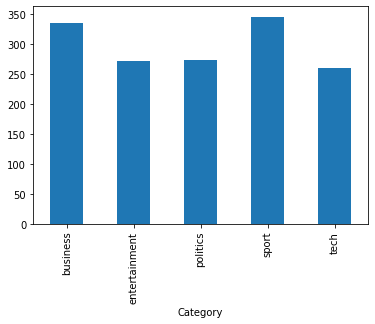

In [8]:
df.groupby('Category').category_id.count().plot.bar(ylim=0)

In [9]:
df.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

We see that the number of articles per class is roughly balanced, which is helpful!

In [10]:
'''
features remaps the words in the 1490 articles in the text column of 
data frame into features (superset of words) with an importance assigned 
based on each words frequency in the document and across documents

# labels represents the category of each of the 1490 articles
'''
tfidf, features, labels = preprocessing(df)

In [11]:
np.random.seed(0)
# Randomly select 30 % of samples
index = np.random.choice(range(len(features)), size=int(len(features)*0.3), replace=False)          
# Array of all projected features of 30% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[index])  

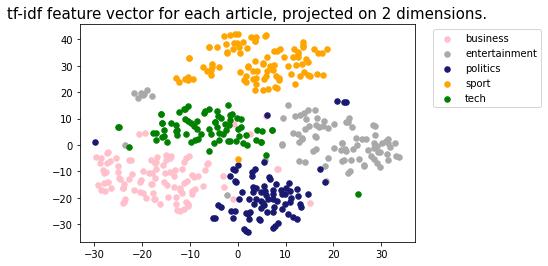

In [12]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[index] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",fontdict=dict(fontsize=15))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

In [14]:
# Create MLP
def build_mlp(hidden_layer_1_size=1024, hidden_layer_2_size=512, dropout_1_2=0.1):
    
    mlp_model = Sequential()

    mlp_model.add(Dense(hidden_layer_1_size, input_dim=X_train.shape[1], activation='tanh'))
    
    if dropout_1_2 > 0.0:
        mlp_model.add(Dropout(dropout_1_2))
    
    if hidden_layer_2_size > 0:
        mlp_model.add(Dense(hidden_layer_2_size, activation='tanh'))
        
    mlp_model.add(Dense(len(category_to_id.keys()), activation='softmax'))

    mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return mlp_model

In [15]:
model = KerasClassifier(build_mlp, verbose=0, hidden_layer_1_size=1024, hidden_layer_2_size=512, dropout_1_2=0.2)

## Testing the model

In [16]:
#Train Algorithm
model.fit(X_train, y_train)
# Make Predictions
y_pred = model.predict(X_test)

In [17]:
print('Accuracy of the model is:', round(accuracy_score(y_pred,y_test),4))

Accuracy of the model is: 0.9776


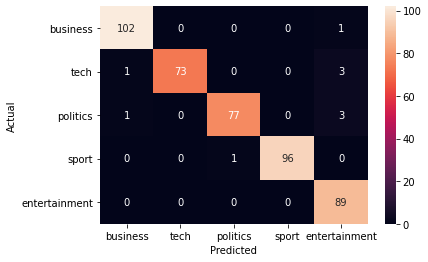

In [18]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sn.heatmap(cm, annot=True, fmt='d', xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
print('Retrieve value for all the class is:\n')
find_retrieve(cm,id_to_category)

Retrieve value for all the class is:



{'business': 0.9902912621359223,
 'entertainment': 1.0,
 'politics': 0.9506172839506173,
 'sport': 0.9896907216494846,
 'tech': 0.948051948051948}

In [20]:
## Print the classification report

target_names = df['Category'].unique()
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

     business       0.98      0.99      0.99       103
         tech       1.00      0.95      0.97        77
     politics       0.99      0.95      0.97        81
        sport       1.00      0.99      0.99        97
entertainment       0.93      1.00      0.96        89

     accuracy                           0.98       447
    macro avg       0.98      0.98      0.98       447
 weighted avg       0.98      0.98      0.98       447

